In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
import seaborn as sns
rng = np.random.default_rng(seed=42)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import ast

In [ ]:

# ==============================================================================
# 📦 DATA LOADING: Parcel shipment data (DHL)
# ------------------------------------------------------------------------------

print("Reading input data...")

# Define coordinate reference system (ETRS89 / UTM zone 32N)
crs = 25832

# Input folder path
folder = "input/"

# File names
dhl_streets_file = "dhl2streets_2021.shp"                   # DHL street segments with daily volume

# -------------------------------------------------------------------------------
# 2. Load DHL street segments (Shapefile), reproject and rename daily volume column
# -------------------------------------------------------------------------------
dhl_streets_gdf = gpd.read_file(folder + dhl_streets_file, encoding='UTF-8')
dhl_streets_gdf = dhl_streets_gdf.to_crs(crs)
dhl_streets_gdf = dhl_streets_gdf.rename(columns={'tagesschni': 'dhl_tag'})  # 'dhl_tag' = daily DHL volume

ga_corrected_b2b_gdf = gpd.read_file("output/05_ga_corrected_b2b_with_marked_adjust_gdf.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
#Convert Columns with Numeric-looking Strings to Proper Numeric Format
# Convert 'object'-type columns to numeric if possible
for col in ga_corrected_b2b_gdf.select_dtypes(include=["object"]).columns:
    if col.startswith("market_shares_"):
        # Try to parse as dictionary
        ga_corrected_b2b_gdf[col] = ga_corrected_b2b_gdf[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
    elif col != "geometry":  # avoid geometry column
        try:
            converted = pd.to_numeric(ga_corrected_b2b_gdf[col], errors="coerce")
            if converted.notna().sum() > 0.9 * len(ga_corrected_b2b_gdf):
                ga_corrected_b2b_gdf[col] = converted
        except Exception as e:
            print(f"Skipping column {col} due to error: {e}")
            pass

# Set CRS for the grid if missing
if ga_corrected_b2b_gdf.crs is None:
    ga_corrected_b2b_gdf.set_crs("EPSG:25832", inplace=True)  

print("Finished reading input data.")



Reading input data...
Finished reading input data.


In [30]:
# Dein Koordinatensystem
crs = 25832  # ETRS89 / UTM zone 32N

# 🔹 Lade Firmen-Geo-Daten
companies_gdf = gpd.read_file(folder + "companies_Total_reduced.shp")
companies_gdf = companies_gdf.to_crs(crs)

# 🔹 Lade Personen-Geo-Daten
persons_gdf = gpd.read_file(folder + "persons_total.shp")
persons_gdf = persons_gdf.to_crs(crs)

print("✅ Both GeoDataFrames loaded and projected.")

✅ Both GeoDataFrames loaded and projected.


In [37]:
dhl_streets_gdf

def sample_streets(strassen_gdf, m=50):
    pts = []
    for idx, row in strassen_gdf.iterrows():
        parts = round(row['geometry'].length/m)
        if parts <= 1:
            i = 0
            pt = row['geometry'].interpolate(0.5, normalized=True)

            # idx, i, plz, geom, dhl, hermes, ups, amazon, dpd, gls, fedex
            pts.append([idx, i, row['plz'], pt, row["name"]])
        else:
            delta = row['geometry'].length % m / 2

            for i in range(parts):
                intp = delta + i*m
                pt = row['geometry'].interpolate(intp)
                
                # idx, i, plz, geom, dhl, hermes, ups, amazon, dpd, gls, fedex
                pts.append([idx, i, row['plz'], pt, row["name"]])
    pt_gdf = gpd.GeoDataFrame(pts, crs='EPSG:32632', geometry='geometry', 
    columns=['str_idx', 'str_part', 'plz', 'geometry', "name"])  

    return pt_gdf
    
samples = sample_streets(dhl_streets_gdf)

<Axes: >

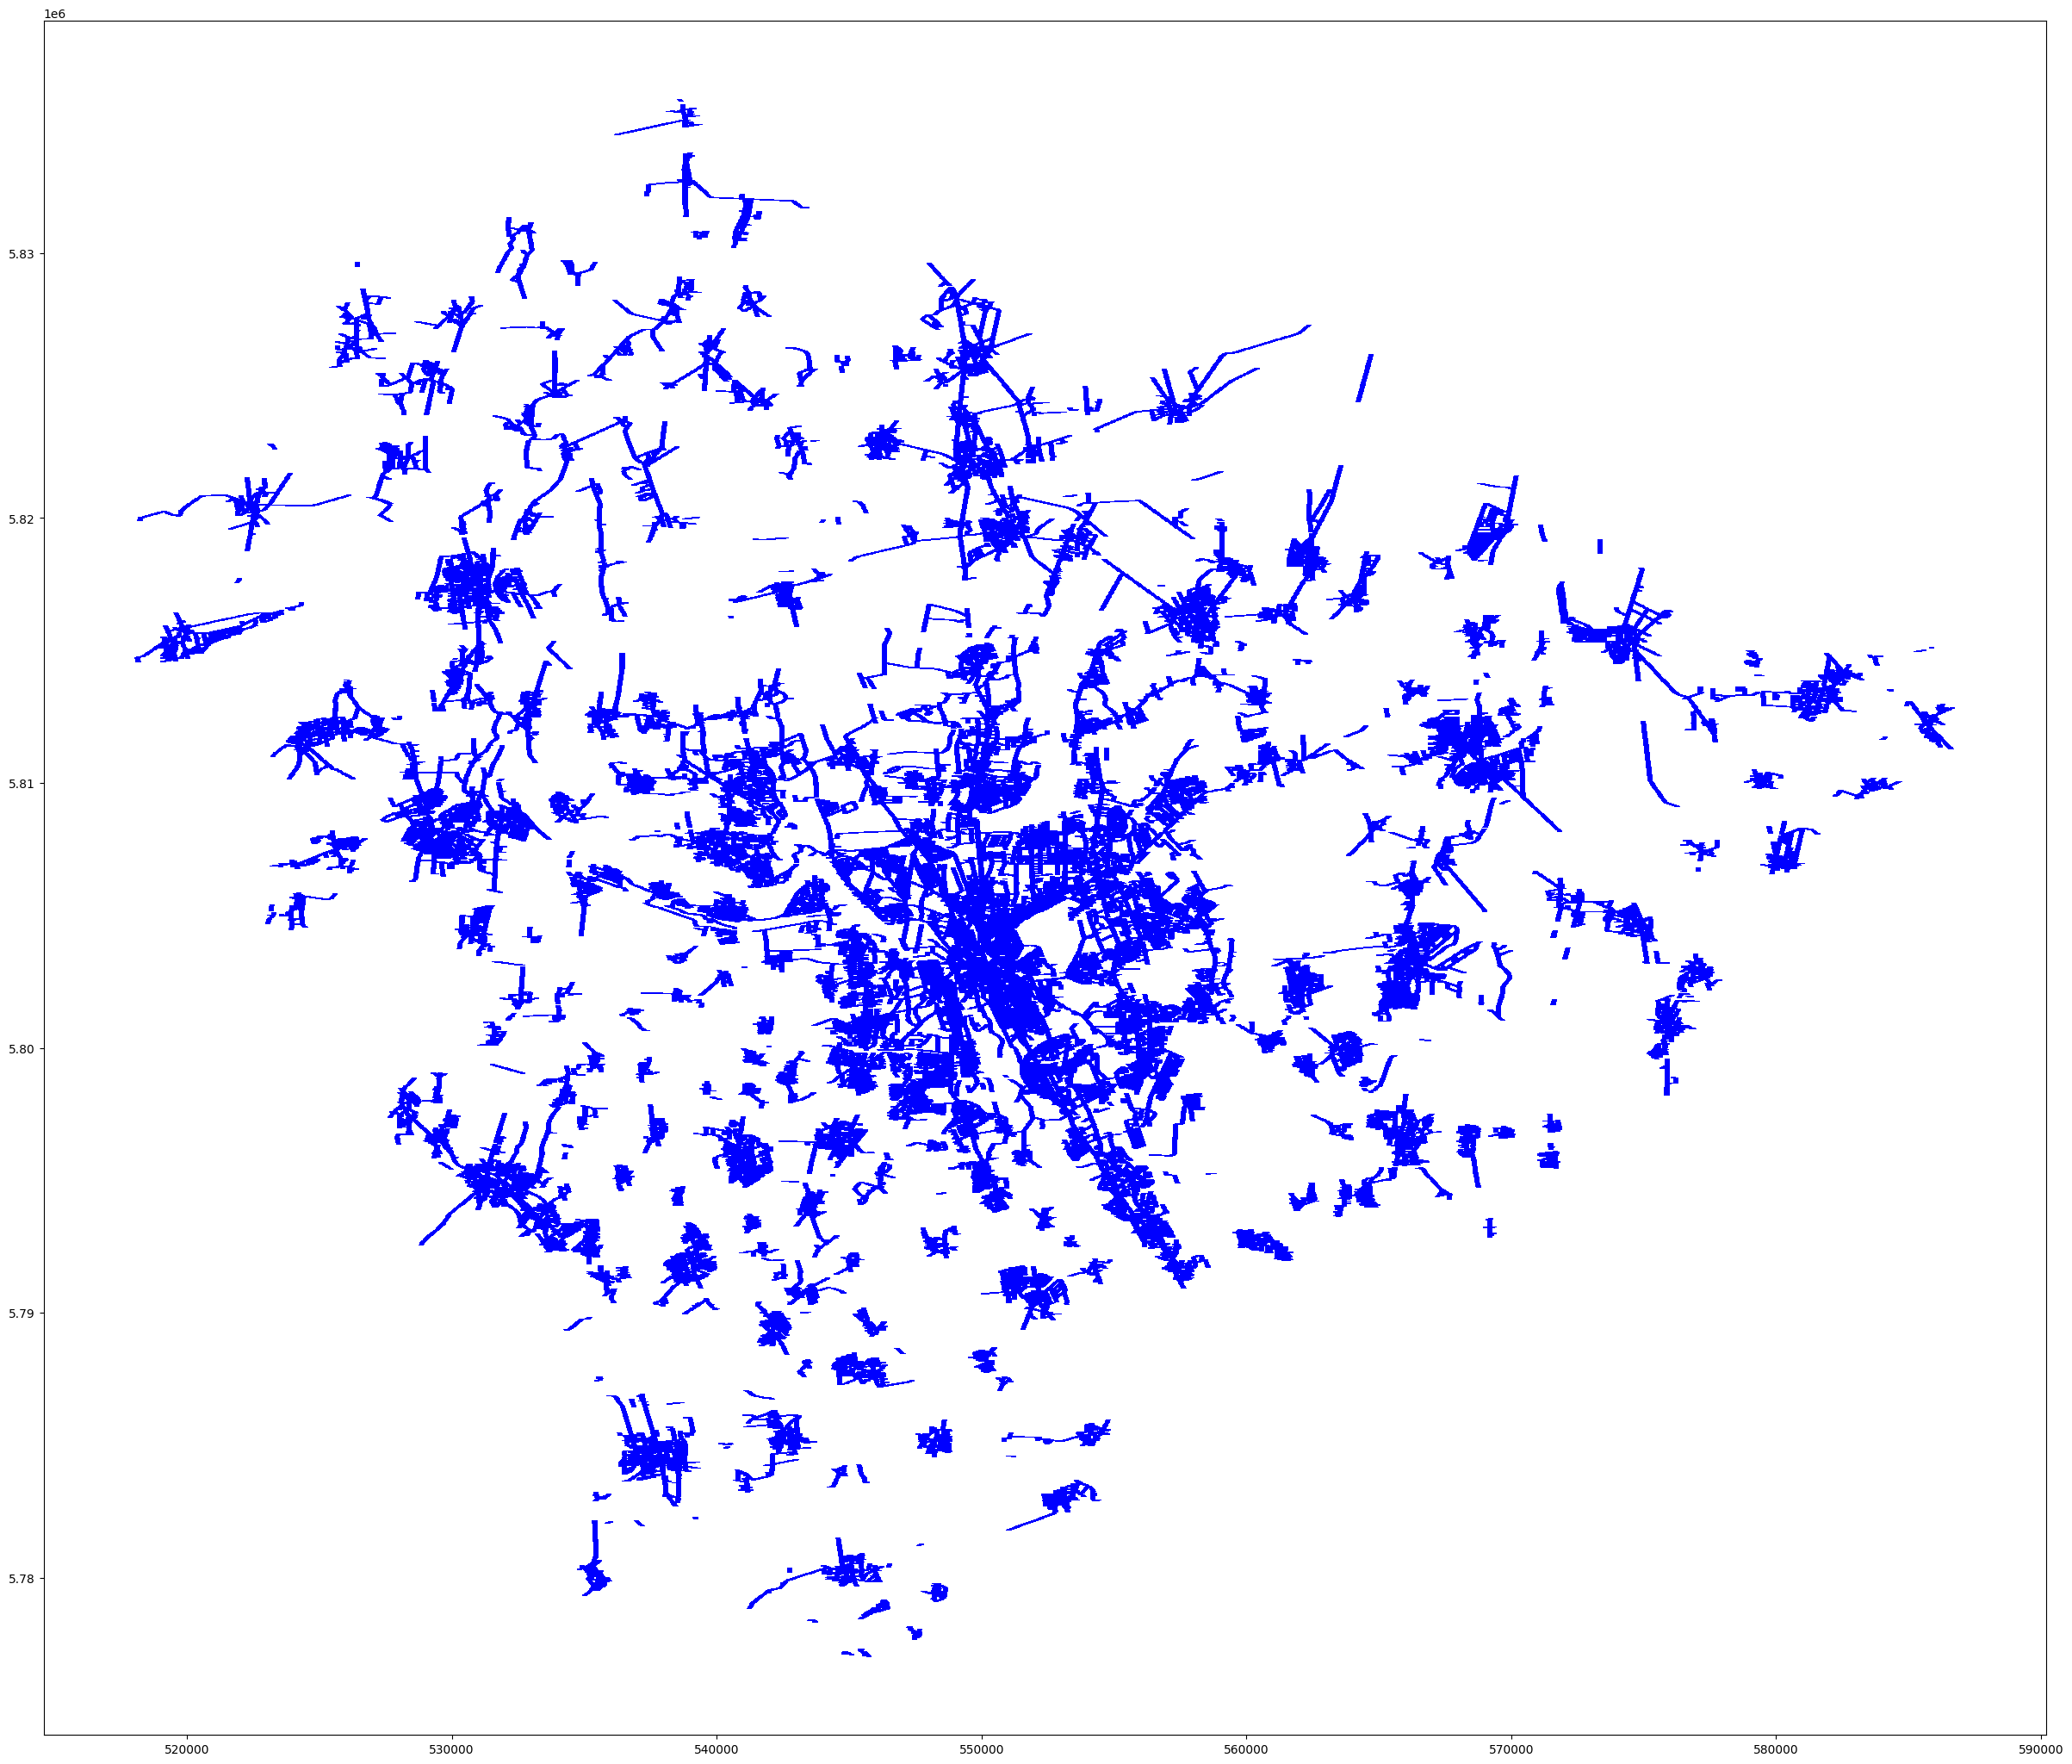

In [58]:
from shapely.geometry import box

def point_to_rectangle(point, length=50, width=50):
    """
    Creates a rectangle centered on a point with given dimensions.
    Length = in Fahrtrichtung (z. B. entlang der Straße),
    Width  = quer zur Straße (z. B. 15 m links + 15 m rechts)
    """
    x, y = point.x, point.y
    return box(x - length / 2, y - width / 2, x + length / 2, y + width / 2)

target_crs = "EPSG:25832"
samples['geometry_buffer'] = samples['geometry'].apply(lambda p: point_to_rectangle(p, length=200, width=50))
bufferd_samples = gpd.GeoDataFrame(samples.drop(columns='geometry'), geometry='geometry_buffer', crs=target_crs)

bufferd_samples.plot(figsize=(30, 30), color='blue', alpha=1)


In [59]:
def assign_b2c_b2b_weights(buffered_samples, companies_gdf, persons_gdf, alpha=1.0, beta=0.02):
    """
    Assigns realistic B2C and B2B weights to rectangular samples:
    - B2C: count persons
    - B2B: α * number of companies + β * number of employees

    Parameters:
    -----------
    buffered_samples : GeoDataFrame
        Rechtecke entlang der Straße
    companies_gdf : GeoDataFrame
        Unternehmensdaten mit optionaler 'employees'-Spalte
    persons_gdf : GeoDataFrame
        Punktdaten, eine Zeile pro Person oder Haushalt
    alpha : float
        Gewicht pro Firma
    beta : float
        Gewicht pro Mitarbeitendem

    Returns:
    --------
    GeoDataFrame mit 'b2c_weight', 'b2b_weight', 'company_count'
    """

    # --- B2C: Personen pro Rechteck
    b2c_join = gpd.sjoin(buffered_samples, persons_gdf, how="left", predicate="contains")
    b2c_counts = b2c_join.groupby(b2c_join.index).size()
    buffered_samples["b2c_weight"] = buffered_samples.index.map(b2c_counts).fillna(0).astype(int)

    # --- B2B: Firmen + Mitarbeitende
    b2b_join = gpd.sjoin(buffered_samples, companies_gdf, how="left", predicate="contains")

    company_counts = b2b_join.groupby(b2b_join.index).size()
    buffered_samples["company_count"] = buffered_samples.index.map(company_counts).fillna(0).astype(int)

    if "employees" in companies_gdf.columns:
        employee_sums = b2b_join.groupby(b2b_join.index)["employees"].sum()
        buffered_samples["employees_sum"] = buffered_samples.index.map(employee_sums).fillna(0).astype(int)
    else:
        buffered_samples["employees_sum"] = 0

    # Gewichtete Kombination
    buffered_samples["b2b_weight"] = (
        alpha * buffered_samples["company_count"] +
        beta * buffered_samples["employees_sum"]
    ).round(5)

    # Filter: Nur sinnvolle Einträge
    mask = (buffered_samples["b2c_weight"] > 0) | (buffered_samples["b2b_weight"] > 0)
    return buffered_samples[mask].copy()

samples_weighted = assign_b2c_b2b_weights(
    buffered_samples=bufferd_samples,
    companies_gdf=companies_gdf,
    persons_gdf=persons_gdf,
    alpha=1.0,
    beta=0.02
)

c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\geopandas\plotting.py:967: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.draw()
C:\Users\bienzeisler\AppData\Local\Temp\ipykernel_21128\77753752.py:29: UserWarning: Glyph 127981 (\N{FACTORY}) missing from current font.
  plt.tight_layout()
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bienzeisler\Anaconda3\envs\matsim_geo_environment\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


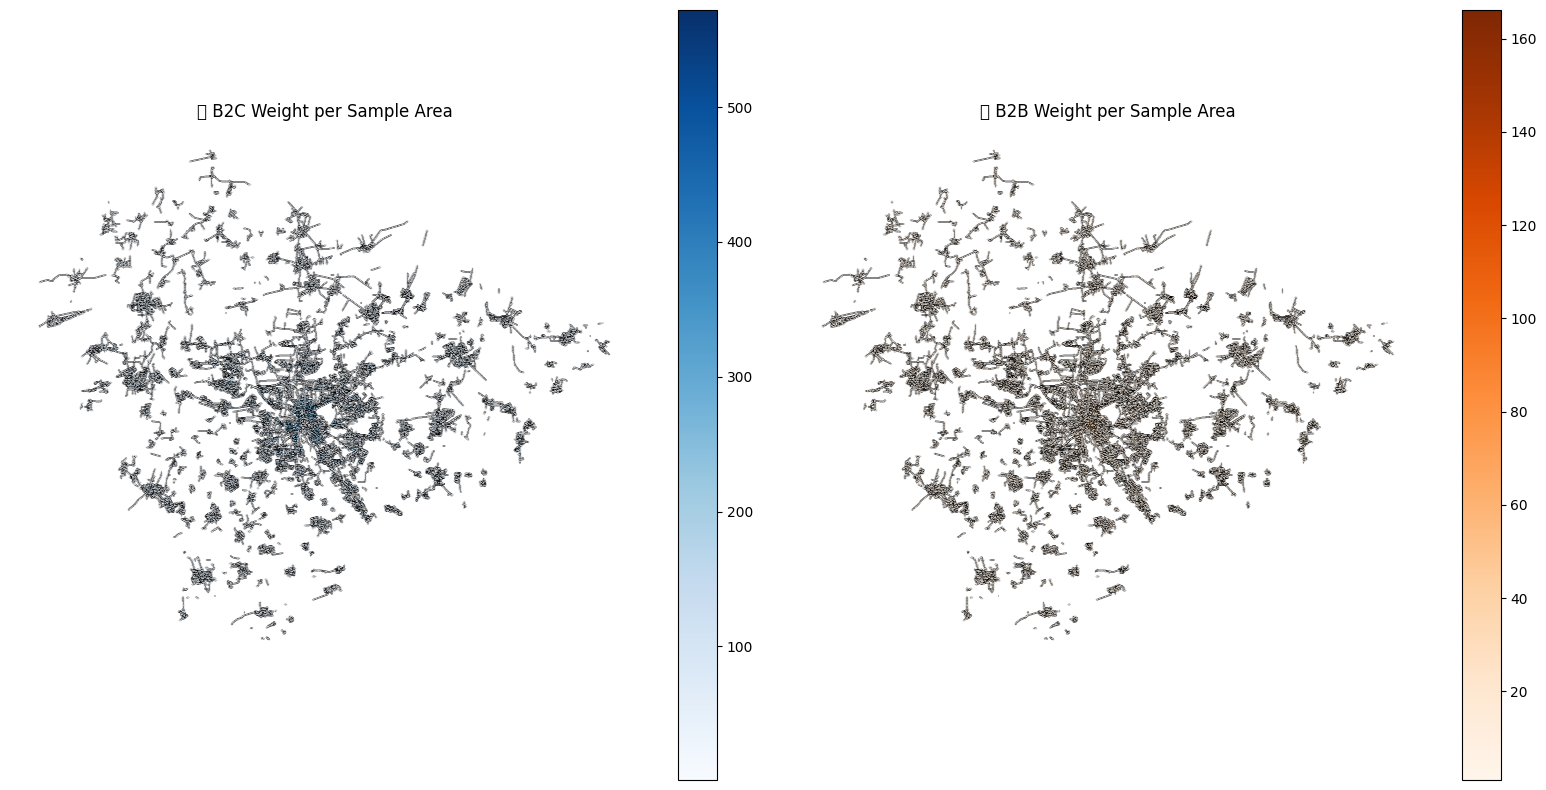

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 📦 B2C
samples_weighted.plot(
    column="b2c_weight",
    cmap="Blues",
    legend=True,
    ax=ax[0],
    edgecolor="black",
    linewidth=0.1
)
ax[0].set_title("📦 B2C Weight per Sample Area")
ax[0].axis("off")

# 🏭 B2B
samples_weighted.plot(
    column="b2b_weight",
    cmap="Oranges",
    legend=True,
    ax=ax[1],
    edgecolor="black",
    linewidth=0.1
)
ax[1].set_title("🏭 B2B Weight per Sample Area")
ax[1].axis("off")

plt.tight_layout()
plt.show()
